# Problem 1 - Edges And Lines
## Brieuc POPPER

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1a

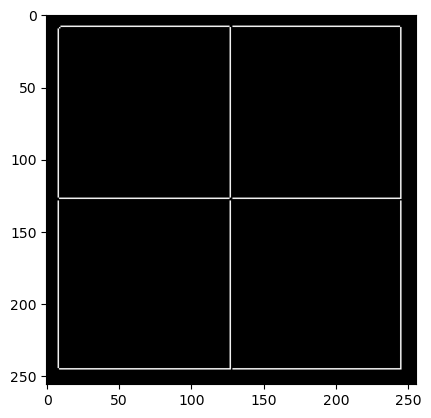

In [3]:
#open the provided image

img = cv2.imread('ps1-input0.png')
#img = cv2.imread('testrotated.png')

edgesImg = cv2.Canny(img,100,200)

def showImageBW(image):
    plt.imshow(image,cmap='gray')
    plt.show()


showImageBW(edgesImg)

This image above is the edge image, obtained with Canny

## 2

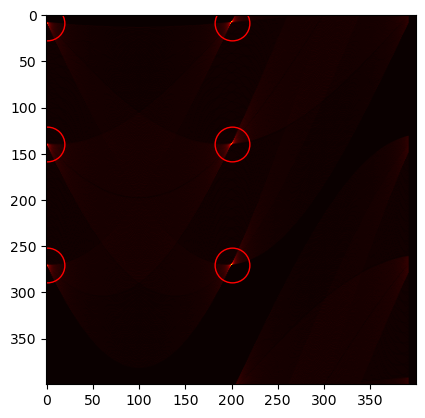

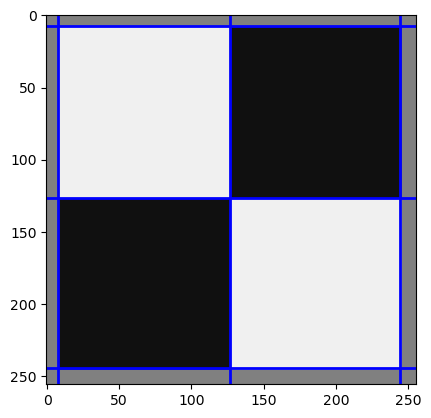

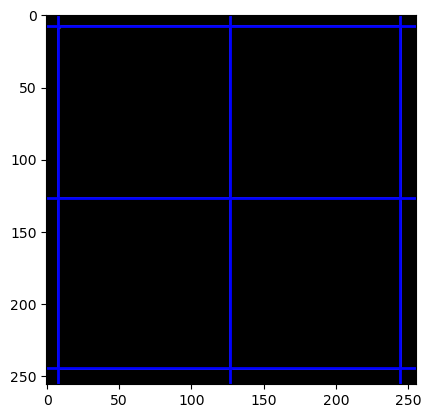

[(244.37610357807085, 0.0),
 (244.37610357807085, 1.5707963267948966),
 (126.71353518862932, 0.0),
 (126.71353518862932, 1.5707963267948966),
 (7.240773439350248, 0.0),
 (7.240773439350248, 1.5707963267948966)]

In [41]:
def distAndAngleToLine(distance,angle,imageshape):
    xSize=imageshape[0]
    ySize=imageshape[1] 

    #return a tuple of two XY points

    vector=np.array([np.sin(angle),np.cos(angle)])


    vector=distance*vector



    normalVector=np.array([-vector[1],vector[0]])

    #now we have a vector and a normal vector





    point2=vector+normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)
    point1=vector-normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)

    



    return [point1,point2]






def hough(edgeImage,originalImg,total_d_Divisions,angleDivisions,avoidCloseLines,totalLines,radius,verbose=False,showRadius=False):

    #radius is bigger if you want to avoid close lines

    maxDist=np.sqrt((edgeImage.shape[0])**2+(edgeImage.shape[1])**2)
    
    #create an empty 2d array of zeros 
    accumulator = np.zeros((total_d_Divisions,angleDivisions))

    #create an array of 2d points which are edges

    edges=[]
    for i in range(edgeImage.shape[0]):
        for j in range(edgeImage.shape[1]):
            if edgeImage[i][j]>1:
                edges.append((i,j))



    for edge in edges:
        x=edge[0]
        y=edge[1]

        for angle in range(angleDivisions-int(angleDivisions/50)): #The /50 prevents having lines at pi or very close to pi, which wouldnt be good anyway
            theta=angle/angleDivisions*np.pi
            #theta varies from 0 to pi

            d=np.cos(theta)*x+np.sin(theta)*y

            #round d to the nearest accumulator spot
            #d can go from -maxDist to maxDist
            
            
            dIndex=d/maxDist*total_d_Divisions #is between 0 and max total d divisions
            accumulator[int(dIndex)][angle]+=1

    





    #totalLines is the total number of lines we want to find

    maxIndexes=np.zeros((totalLines,2))

    #create a copy of the accumulator used to find the maxes
    accumulatorCopy=accumulator.copy()
    #keep only half of the accumulator on the axis of angle
    #accumulatorCopy=accumulatorCopy[:,0:int(accumulatorCopy.shape[1]/2)]

    

    if not avoidCloseLines:
        for i in range(totalLines):
            maxIndexes[i]=np.unravel_index(np.argmax(accumulatorCopy, axis=None), accumulatorCopy.shape)
            accumulatorCopy[int(maxIndexes[i][0])][int(maxIndexes[i][1])]=0
            #in this case close we can have close lines


    else:
        for i in range(totalLines):
                #find one max, then set the accumulator to 0 in a square of size 7x7 centered on the max
                maxIndexes[i]=np.unravel_index(np.argmax(accumulatorCopy, axis=None), accumulatorCopy.shape)

                currentX=int(maxIndexes[i][0])
                currentY=int(maxIndexes[i][1])

                for squareX in range(-radius+1,radius):
                    for squareY in range(-radius+1,radius):
                        X_tolower=currentX+squareX
                        X_tolower=min(X_tolower,accumulatorCopy.shape[0]-1)
                        X_tolower=max(X_tolower,0)

                        Y_tolower=currentY+squareY

                        Y_tolower=min(Y_tolower,accumulatorCopy.shape[1]-1)
                        Y_tolower=max(Y_tolower,0)
                        accumulatorCopy[X_tolower][Y_tolower]=accumulatorCopy[X_tolower][Y_tolower]/1000


                        
                        

                #in this case we avoid close lines
    if(showRadius):
        plt.imshow(accumulatorCopy,cmap='hot')
        plt.show()
   
    
    plt.imshow(accumulator,cmap='hot')
    #multiple cmaps exist, such as 'gray' and 'viridis' and 'hot'


    #add 6 circles on the image, the circles should be empty inside
    #their centers are the maxIndexes

    for i in range(totalLines):
        plt.plot(maxIndexes[i][1],maxIndexes[i][0],'ro',fillstyle='none',markersize=25)

    plt.show()
    


    #now we need to convert the maxIndexes to lines

    #we know a max index is a distance, angle tuple
    plt.imshow(originalImg,cmap='gray')
    #figure out where the lines interesect the border of the image

    #ignore d for now
    l1 = [(0,0),(0,0)]
    #colors=['red','blue','green','yellow','purple','orange','pink','brown','black','white']
    colors=[]
    lines=[[(0,0),(0,0)] for _ in range(totalLines)]
    counter=0
    lineDistTheta=[]
    for point in maxIndexes:
        
        #dIndex=(d/maxDist+1)*total_d_Divisions
        #theta=angle/angleDivisions*np.pi

        distance=(point[0]/total_d_Divisions)*maxDist
        theta=point[1]/angleDivisions*np.pi

        #theta=angle/angleDivisions*np.pi
        
        if(verbose):
            print(distance,theta,'distance and angle')
        
        if theta>np.pi/2 and theta<3:
            lines[counter]=distAndAngleToLine(distance,theta,img.shape)
            lineDistTheta.append((distance,theta))
            colors.append('red')
        elif theta>=3:
            lines[counter]=distAndAngleToLine(distance,theta,img.shape)
            lineDistTheta.append((distance,theta))
            colors.append('green')
        else:
            lines[counter]=distAndAngleToLine(distance,theta,img.shape)
            lineDistTheta.append((distance,theta))
            colors.append('blue')
        

        counter+=1




    # Takes list of lines, where each line is a sequence of coordinates
    from matplotlib.collections import LineCollection
    counter=0
    for l1 in lines:
        lc = LineCollection([l1], color=colors[counter], lw=2)
        counter+=1

        plt.gca().add_collection(lc)
    plt.show()

    plt.imshow(edgeImage,cmap='gray')
    for l1 in lines:
        lc = LineCollection([l1], color=["blue"], lw=2)

        plt.gca().add_collection(lc)
    plt.show()

    return lineDistTheta


#arguments are edgeImage,total_d_Divisions,angleDivisions,avoidCloseLines
hough(edgesImg,img,400,400,True,6,10,showRadius=False)






My bin sizes are 400 and 400 (for distance and angle respectively)

The problem if you have a too small bin size for the angle is that you won't have the slope precise enough to really match your image.

A problem if your distance bin size is too small is also a loss in precision (your line can have the right "slope" and be parallel to where the true line should be be offset by a bit)

Also with too small bin sizes it's hard to do the trick that I did to avoid the system picking up too many lines that are very close in Hough space : after getting the maximum of the hough space, you set a small square around this maximum to 0.

Bigger bin sizes make it so we can have cleaner intersections of the sinusoidal curves in hough space and to separate them better. It is not useful to have too big values though as you increase in computational time and in memory requirements.

Finally the way the code is implemented (doing a for loop on theta) means that if there aren't enough bin sizes in the angle space, because we're adding one point (d,theta) for each theta possible, we better have enough different possible values for theta or we won't add enough points on the accumulator to have clean curves and meaningful intersections, even with a huge bin size for d.

## 3a

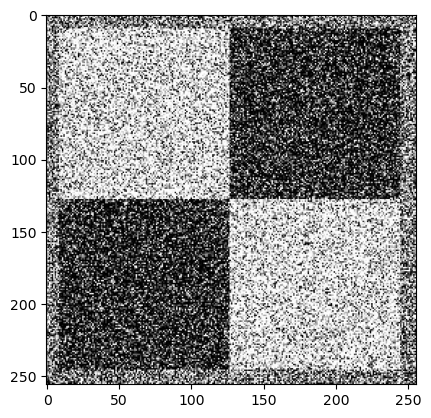

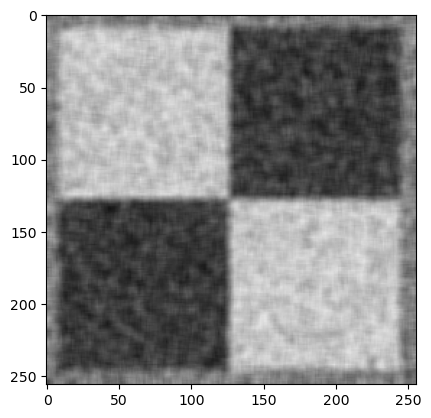

In [5]:
#open the provided image


noisy = cv2.imread('ps1-input0-noise.png')

showImageBW(noisy)

#apply a gaussian blur with cv2.GaussianBlur
#arguments are image, kernel size, sigmaX

noisy=cv2.GaussianBlur(noisy,(7,7),5)

showImageBW(noisy)

This is the smoothed image

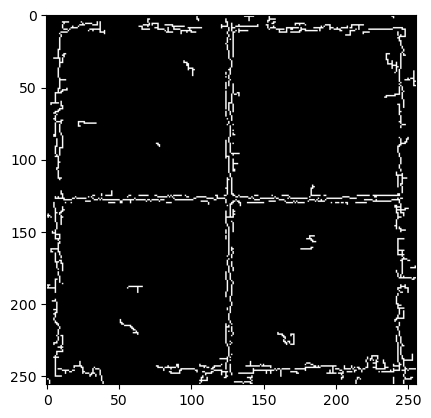

In [6]:
edgesForBlurryImg = cv2.Canny(noisy,80,154)
showImageBW(edgesForBlurryImg)

This is a pretty good edge image, we still see some noise, let's see if our Hough function can figure out where the lines go !

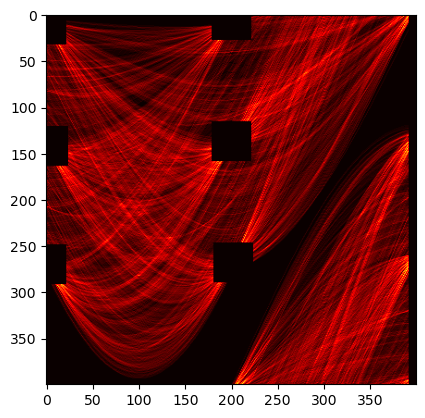

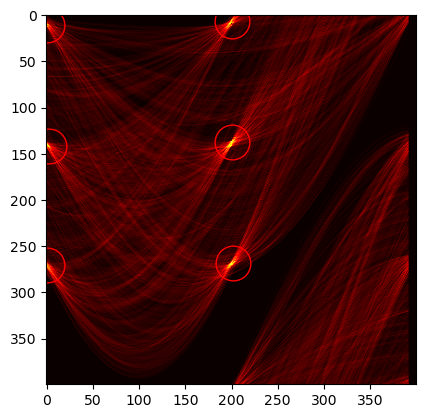

123.998245148873 1.5707963267948966 distance and angle
5.430580079512685 1.5707963267948966 distance and angle
128.5237285484669 0.015707963267948967 distance and angle
242.56591021823328 1.5865042900628454 distance and angle
9.95606347910659 0.0 distance and angle
244.37610357807085 0.0 distance and angle


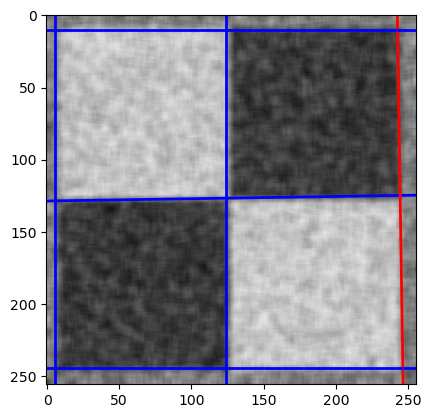

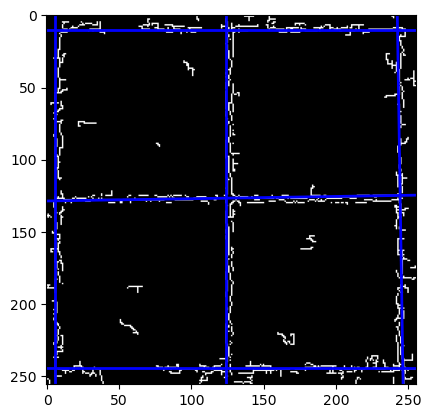

In [7]:
hough(edgesForBlurryImg,noisy,400,400,True,6,22,verbose=True,showRadius=True)

To get the best result I had to do multiple optimizations:

- adjust a bunch the parameters of the canny operation to end up with a good edge image.

- I had to fix a bit my hough algorithm because it often detected lines who had polar coordinates 250 (distance) and 3.1 (angle in radians, almost pi). These intersections are not relevant as they create lines that dont even cross the image and a quick fix I did was to not fill the accumulator for angles very close to pi, which correspond to lines which wouldn't even appear in my image. I chose to work only with positive distances, and the angle going from 0 to (almost) pi.

- Also my hough algorithm, after detecting a maximum, draws a black square in hough space to ensure the second maximum is another line.

Rigourously speaking, I think I shouldn't prevent from filling up my hough space for angles very close to pi, but the fact is that with a big distance and an angle very close to pi (which is visually speaking the far right part of hough space, except the top right) the lines would not appear on my image so I don't draw them, and they shouldn't be contenders for a "maximum" in hough space.

However for any practical case my algorithm has results that are satisfying with this "trick".



## 4

(512, 683)


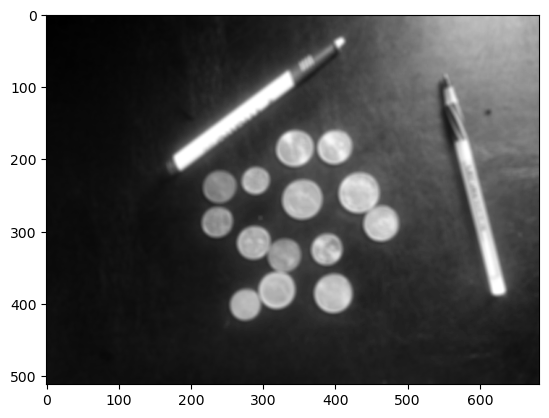

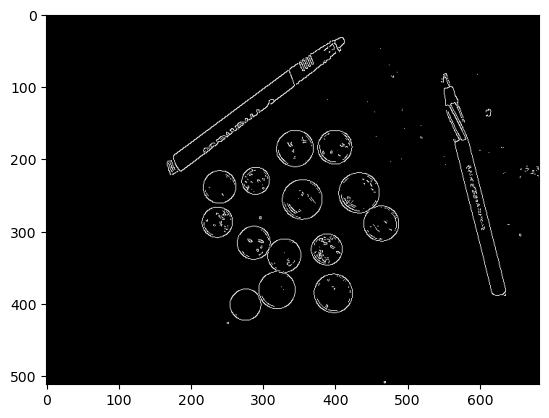

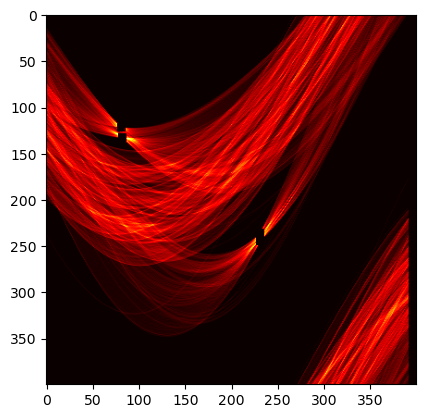

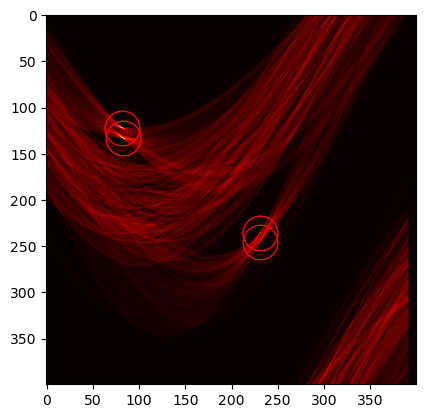

260.3480071462042 0.6361725123519332 distance and angle
283.82200779053414 0.6440264939859075 distance and angle
522.8300143509839 1.8142697574481055 distance and angle
503.62401382380483 1.8142697574481055 distance and angle


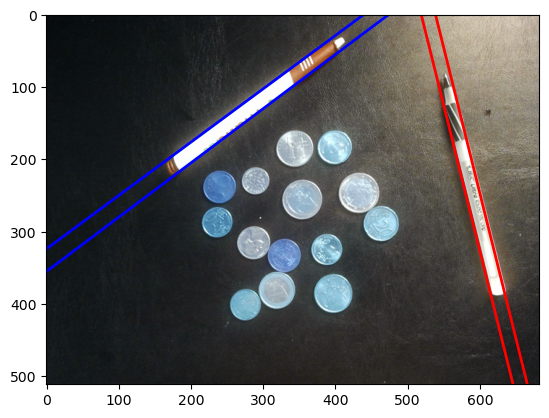

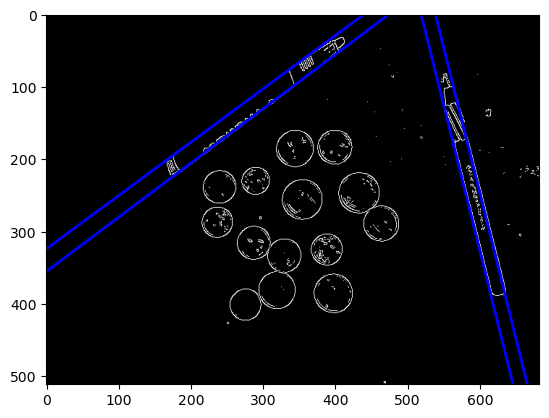

In [8]:
#Import ps1-input.jpg


new = cv2.imread('ps1-input1.jpg',cv2.IMREAD_UNCHANGED)
#convert to grayscale
newGray=cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)

print(newGray.shape)


newGray=cv2.GaussianBlur(newGray,(7,7),3)



showImageBW(newGray)

newEdges = cv2.Canny(new,210,250)
showImageBW(newEdges)


hough(newEdges,new,400,400,True,4,5,verbose=True,showRadius=True)


I didn't need to modify any further my algorithm for this question, once I had a good edge image it worked fine. The lines that show up in different colors are just for debugging purposes, the color depends on the angle.


# 5 - for circles

In [9]:
# now we will create a circle finding version of the Hough transform

#we'll implement the gradient method

def houghCircle(edgeImage,originalImg,totalXdivs,totalYdivs,totalRdivs,thetaPrecision,maxR,avoidCloseCircles,radiusToBlackout,verbose=False,showRadiusBlackedOut=False):

    #radiusToBlackOut is the radius of the circle around a maximum in houghspace
    #where you can't find another maximum


    
    #create an empty 3d array of zeros 
    accumulator = np.zeros((totalRdivs,totalXdivs,totalYdivs))

    #create an array of 2d points which are edges

    edges=[]
    for i in range(edgeImage.shape[0]):
        for j in range(edgeImage.shape[1]):
            if edgeImage[i][j]>1:
                edges.append((i,j))



    for edge in edges:
        x=edge[0]
        y=edge[1]
        maxX=edgeImage.shape[0]
        maxY=edgeImage.shape[1]

        for rDivision in range(totalRdivs):
            for theta in range(thetaPrecision):  #this is usually a number like 360, so you add 360 points in the accumulator per edge
                
                

                xDivision=x/maxX*totalXdivs
                yDivision=y/maxY*totalYdivs



                
                r=rDivision/totalRdivs*maxR

                a=x-r*np.cos(theta)
                b=y+r*np.sin(theta)

                #convert a, b to actual values with the grid
                #rDivision is an actual value on the grid
                
                a=int(a/maxX*totalXdivs)
                b=int(b/maxY*totalYdivs)

                if(a>=0 and a<totalXdivs) and (b>=0 and b<totalYdivs):
                    #in this case the point is actually on the grid
                    accumulator[rDivision][a][b]+=1
                else:
                    pass
            
    return accumulator


In [10]:


# for i in range(acc.shape[0]):
#     np.savetxt('file'+str(i)+'.txt',acc[i,:,:])




def findMaximum(radius,nbMaxs,accumulatorCopy,draw=False,img=None):
    maxIndexes=np.zeros((nbMaxs,2))

    if(draw):
        plt.imshow(accumulatorCopy,cmap='pink')
        plt.show()
    for i in range(nbMaxs):
                
                #find one max, then set the accumulator to 0 in a square of size 7x7 centered on the max
                maxIndexes[i]=np.unravel_index(np.argmax(accumulatorCopy, axis=None), accumulatorCopy.shape)
                currentX=int(maxIndexes[i][0])
                currentY=int(maxIndexes[i][1])

                for squareX in range(-radius+1,radius):
                    for squareY in range(-radius+1,radius):
                        X_tolower=currentX+squareX
                        X_tolower=min(X_tolower,accumulatorCopy.shape[0]-1)
                        X_tolower=max(X_tolower,0)

                        Y_tolower=currentY+squareY

                        Y_tolower=min(Y_tolower,accumulatorCopy.shape[1]-1)
                        Y_tolower=max(Y_tolower,0)
                        accumulatorCopy[X_tolower][Y_tolower]=accumulatorCopy[X_tolower][Y_tolower]/1000
    if(draw):
        for i in range(nbMaxs):
            plt.plot(maxIndexes[i][1],maxIndexes[i][0],'ro',fillstyle='none',markersize=25)
        plt.imshow(accumulatorCopy,cmap='pink')
        #list of all cmap posisble
        #https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        plt.show()

    return(maxIndexes)





def convertXYR2realimage(xGrid,yGrid,rGrid,totalXdivs,totalYdivs,totalRdivs,maxR,img):
    x=xGrid/totalXdivs*img.shape[0]
    y=yGrid/totalYdivs*img.shape[1]
    r=rGrid/totalRdivs*maxR
    return(x,y,r)

def displayCirclesOnOriginalImage(centers,rGrid,originalImage,gridX,gridY,totalRdivs,maxR,newImageStart=False,newImageEnd=False):
    if(newImageStart):
        plt.imshow(originalImage,cmap='gray')
    for center in centers:
        x,y,r=convertXYR2realimage(center[0],center[1],rGrid,gridX,gridY,totalRdivs,maxR,originalImage)

        plt.plot(y,x,'ro',fillstyle='none',markersize=(r+1))
    if(newImageEnd):
        plt.show()



In [11]:


GRIDX=400
GRIDY=600
GRIDR=70
MAXR=40
TOTALMAXIMUMS=3

RADIUSTOLOOK=8
IMG=newEdges
ORIGINAL=new
THETADIVS=88



acc=np.zeros((GRIDR,GRIDX,GRIDY))


def loadAcc():
    #load the filei.npy files

    for i in range(acc.shape[0]):
        acc[i,:,:]=np.load('file'+str(i)+'.npy')


#BELOW STEP TO COMPUTE IT
#delete all npy files in directory
def computeAcc():
    import os, glob
    files = glob.glob('*.npy')
    for f in files:
        os.remove(f)
    acc=houghCircle(IMG,ORIGINAL,GRIDX,GRIDY,GRIDR,THETADIVS,MAXR,True,1,verbose=False,showRadiusBlackedOut=False)
    for i in range(acc.shape[0]):

        #save 2d slice in npy file

        np.save('file'+str(i)+'.npy', acc[i,:,:])



loadAcc()








A few steps that made this work


- First debugging and getting the "Slices" for a given r of the hough space, which took some time.


- I tried pre-computing once and for all the array (big time to compute : 5 to 15 minutes for high-precision circle detection) and saving it to text files (one file per 2d slice)


- Once the hough space was computed, if I wanted 5 circles, I calculated 30 maximums in Hough space (without choosing maximums too close to each otehr), and then gave each max a score: Score = (intensity**2 / average intensity around the max). I then only keep the top 5 scores, and this really made a huge difference in the performance of my algorithm.

- Finally I don't let the maximums be for radius less than 5 pixels, because then all my 30 maximums are for circles with radius 1 to 5 and I can't detect actual meaningful circles in the image.

The reasoning behind the score came by looking at a lot of 2d slices of hough space, in which I noticed that an actual circle that you should detect is with a very bright point, with it's neighboorhood very quickly fading to very dark values, as opposed to a "large" maximum which means you've got the radius wrong by a bit.


(70, 400, 600)
ABOVE IS THE SHAPE OF ACC WE ARE SEARCHING IN WITHOUT RESTRCITIONS ON R
[[942.85718135]
 [813.66486486]
 [726.10158122]
 [778.8414282 ]
 [689.39431616]
 [704.74714778]
 [673.78330614]
 [673.96654882]
 [618.50447227]
 [585.23060517]
 [561.78093923]
 [539.08214585]
 [471.02304636]
 [430.00820691]
 [269.78029121]
 [270.63522839]
 [235.18729747]
 [198.33666476]
 [233.70625841]
 [241.91183971]
 [253.26580159]
 [225.1775214 ]
 [223.30867545]
 [208.30310694]
 [263.84615385]
 [248.21347806]
 [219.11087778]
 [202.52445652]
 [216.83416459]
 [248.31175631]
 [214.42786683]
 [220.77994075]
 [254.48926829]
 [187.11446921]
 [226.625     ]
 [267.86480319]
 [206.13125549]
 [201.41730856]
 [161.41176471]
 [217.0546875 ]]
[[ 14 186 210]
 [ 21 301 348]
 [ 16 143 350]
 [ 12 224 207]
 [ 12 254 340]
 [  8 179 254]
 [ 15 260 289]
 [ 19 298 280]
 [ 24 192 379]
 [ 15 246 251]
 [ 13 313 242]
 [ 23 200 310]
 [ 19 145 302]
 [ 17 226 406]
 [  1 254 334]
 [  2 251 345]
 [  1  63 309]
 [  0 260 342]
 [

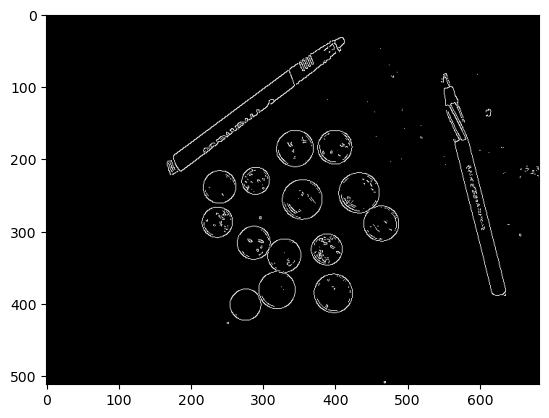

below is rxy
17 226 406
below is rxy
19 145 302
below is rxy
23 200 310
below is rxy
13 313 242
below is rxy
15 246 251
below is rxy
24 192 379
below is rxy
15 260 289
below is rxy
19 298 280
below is rxy
12 254 340
below is rxy
8 179 254
below is rxy
16 143 350
below is rxy
12 224 207
below is rxy
21 301 348
below is rxy
14 186 210


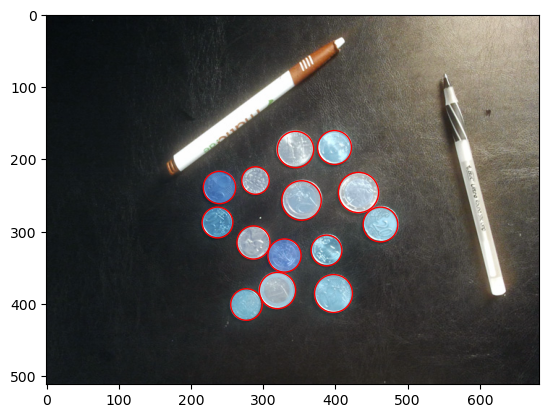

In [12]:
def computeAverageAround3Dpoint(point,acc,radius=3):
      #computes average in a 7x7x7 cube around the point
    currentX=point[0]
    currentY=point[1]
    currentZ=point[2]
    average=0
    for squareX in range(-radius+1,radius):
                    for squareY in range(-radius+1,radius):
                        for squareZ in range(-radius+1,radius):
                            X_tolower=currentX+squareX
                            X_tolower=min(X_tolower,acc.shape[0]-1)
                            X_tolower=max(X_tolower,0)

                            Y_tolower=currentY+squareY
                            Y_tolower=min(Y_tolower,acc.shape[1]-1)
                            Y_tolower=max(Y_tolower,0)

                            Z_tolower=currentZ+squareZ
                            Z_tolower=min(Z_tolower,acc.shape[2]-1)
                            Z_tolower=max(Z_tolower,0)
                            average+=acc[X_tolower][Y_tolower][Z_tolower]
    average=average/(1+radius*2)**3
    return average
#acc is our 3d space
def searchSpace(minR,maxR,acc,poolSize,nbCirclesSearchedFor,radius=3): #radius = 3 means we blackout a 7x7x7 cube
    print(acc.shape)
    print("ABOVE IS THE SHAPE OF ACC WE ARE SEARCHING IN WITHOUT RESTRCITIONS ON R")
    acc=acc[minR:maxR,:,:]
    maxIndexes=np.zeros((poolSize,3))
    accCopy=acc.copy()
    for i in range(poolSize):
                #find one max, then set the accumulator to 0 in a square of size 7x7 centered on the max
                maxIndexes[i]=np.unravel_index(np.argmax(accCopy, axis=None), accCopy.shape)

                currentX=int(maxIndexes[i][0])
                currentY=int(maxIndexes[i][1])
                currentZ=int(maxIndexes[i][2])

                for squareX in range(-radius+1,radius):
                    for squareY in range(-radius+1,radius):
                        for squareZ in range(-radius+1,radius):
                            X_tolower=currentX+squareX
                            X_tolower=min(X_tolower,accCopy.shape[0]-1)
                            X_tolower=max(X_tolower,0)

                            Y_tolower=currentY+squareY
                            Y_tolower=min(Y_tolower,accCopy.shape[1]-1)
                            Y_tolower=max(Y_tolower,0)

                            Z_tolower=currentZ+squareZ
                            Z_tolower=min(Z_tolower,accCopy.shape[2]-1)
                            Z_tolower=max(Z_tolower,0)

                            accCopy[X_tolower][Y_tolower][Z_tolower]=accCopy[X_tolower][Y_tolower][Z_tolower]/1000

    #cast maxIndexes to int
    maxIndexes=maxIndexes.astype(int)
    scores=np.zeros((poolSize,1))
    #each maxIndex is given a score based on it's intensity vs the average intensity around it
    for i in range(poolSize):

        scores[i]=((acc[maxIndexes[i][0]][maxIndexes[i][1]][maxIndexes[i][2]])**2)/(computeAverageAround3Dpoint(maxIndexes[i],acc,radius=3))
    print(scores)

    print(maxIndexes)
    #sort the maxIndexes based on their scores
    maxIndexes=maxIndexes[np.argsort(scores,axis=0)]
    print('below this is the sorted maxIndexes')
    print(maxIndexes)
    #keep the last nbCirclesSearchedFor maxIn dexes
    maxIndexes=maxIndexes[-nbCirclesSearchedFor:,:]

    return(maxIndexes)


                               
                            
                               


MIN_R = 25
MAX_R = 68
maxx=searchSpace(MIN_R,MAX_R,acc,40,14,radius=8)


#draw the circles
counter=0
plt.imshow(newEdges,cmap='gray')
plt.show()
for i in range(len(maxx)):
    thismax=maxx[i][0]

    r=thismax[0]
    x=thismax[1]
    y=thismax[2]
    
    print("below is rxy")
    print(r,x,y)
    if(counter==0):
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageStart=True)
    elif counter==len(maxx)-1:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageEnd=True)
    else:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR)


This is a really good performance ! Let's see if we can keep it up on more realistic images, with tougher conditions.

# 6 - more realistic images - part 1 : lines

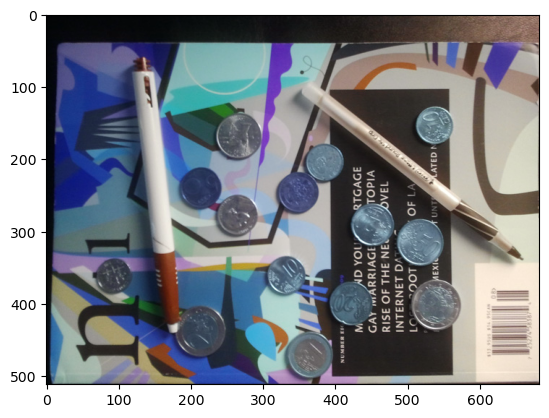

(512, 683)


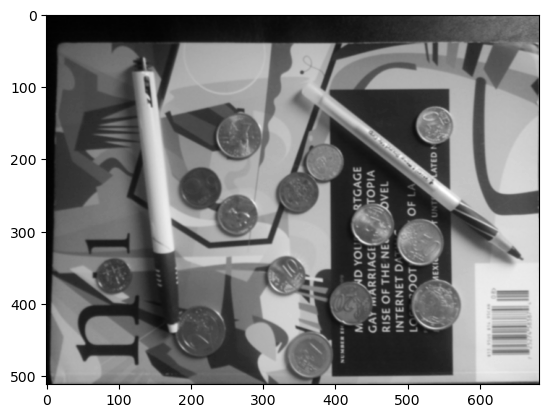

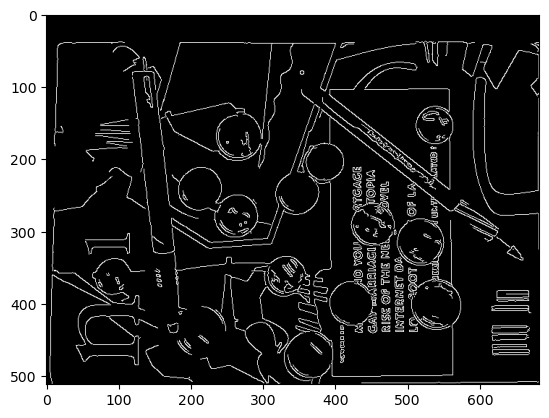

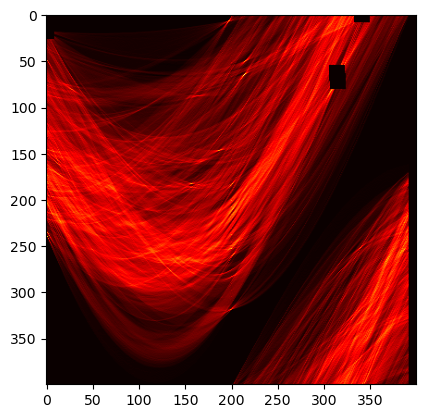

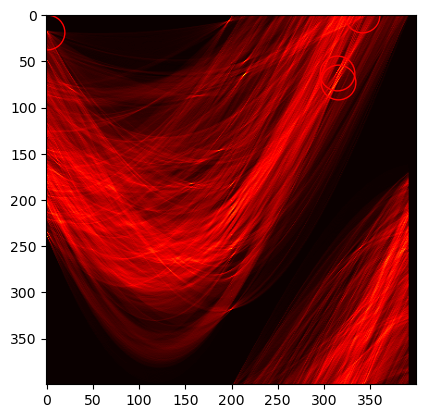

38.412001054358 0.0 distance and angle
153.648004217432 2.474004214701962 distance and angle
0.0 2.6782077371852986 distance and angle
134.442003690253 2.466150233067988 distance and angle


/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3567958955.py:22: RuntimeWarning: invalid value encountered in divide
  point2=vector+normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)
/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3567958955.py:23: RuntimeWarning: invalid value encountered in divide
  point1=vector-normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)


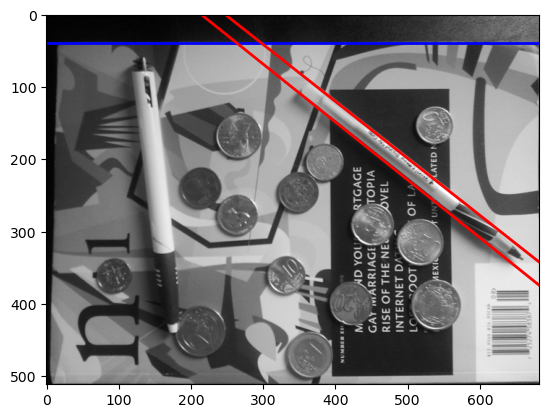

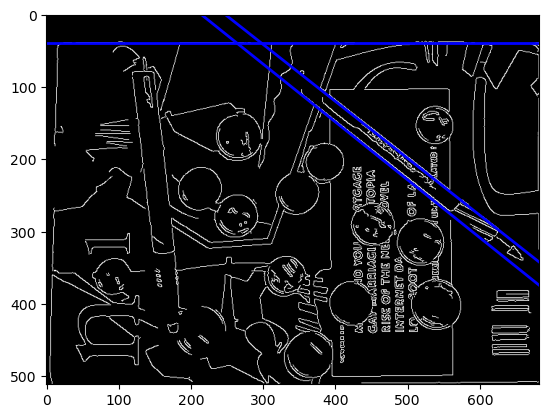

In [13]:
# now we use ps1-input2.jpg

ps1in2=cv2.imread('ps1-input2.jpg',cv2.IMREAD_UNCHANGED)

#first let's pre=process to find the edges

plt.imshow(ps1in2)
plt.show()

ps1in2=cv2.cvtColor(ps1in2, cv2.COLOR_BGR2GRAY)

print(ps1in2.shape)

blurred=cv2.GaussianBlur(ps1in2,(7,7),0.8)

plt.imshow(blurred,cmap='gray')
plt.show()
#apply canny edge detection
edges = cv2.Canny(blurred,100,200)

plt.imshow(edges,cmap='gray')
plt.show()

#find the best 4 lines

hough(edges,ps1in2,400,400,True,4,9,verbose=True,showRadius=True)
#the hough arguments are edgeImage,originalImg,total_d_Divisions,angleDivisions,avoidCloseLines,totalLines,radius,verbose=False,showRadius=False


As we can see when looking at the hough space and the edge image, there are many potential lines to be found because of the background edges.

The hough space is very cluttered and it's uncelar which lines are to be chosen as the top 4 lines (we hoped that the top 4 lines would be the pen edges)




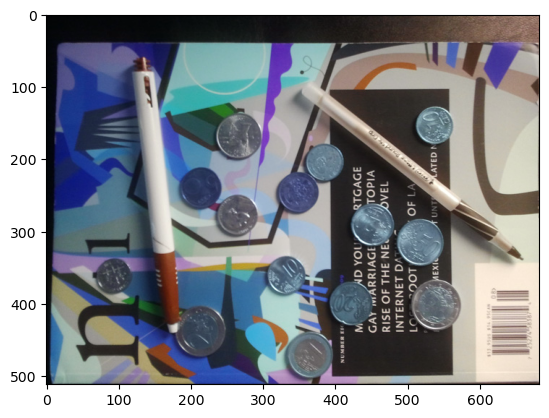

(512, 683)


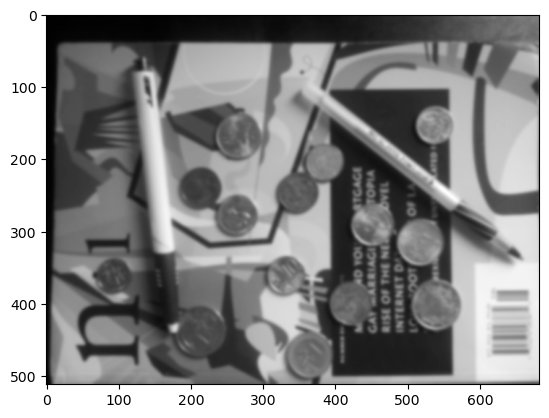

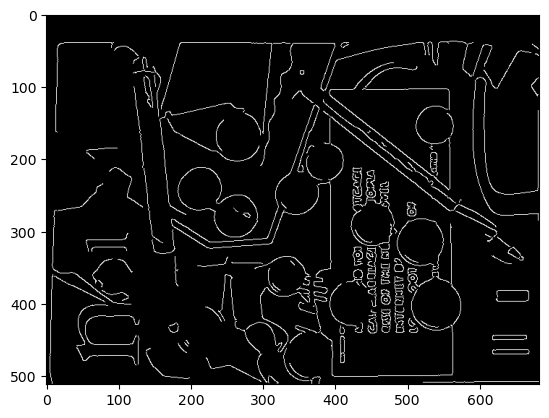

In [62]:
#now we want to find stronger edges, check the lines are not too short, and look for other nearby parallel lines

ps1in2=cv2.imread('ps1-input2.jpg',cv2.IMREAD_UNCHANGED)

#first let's pre=process to find the edges

plt.imshow(ps1in2)
plt.show()

ps1in2=cv2.cvtColor(ps1in2, cv2.COLOR_BGR2GRAY)

print(ps1in2.shape)

blurred=cv2.GaussianBlur(ps1in2,(23,23),2)

plt.imshow(blurred,cmap='gray')
plt.show()
#apply canny edge detection
edges = cv2.Canny(blurred,78,120)





plt.imshow(edges,cmap='gray')
plt.show()




it is very difficult to have the edges of the pen come out clean without too much other edges that could be good candidates for long and parralel lines

We will take the top 20 lines found in the image, and give a "bonus" to lines which have very similar angle to another line in the image (this is to encourage detection of parallel lines)

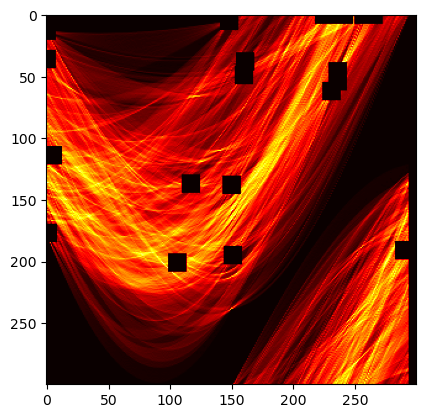

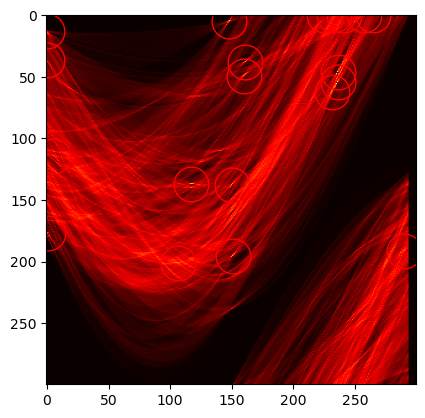

/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:22: RuntimeWarning: invalid value encountered in divide
  point2=vector+normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)
/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:23: RuntimeWarning: invalid value encountered in divide
  point1=vector-normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)


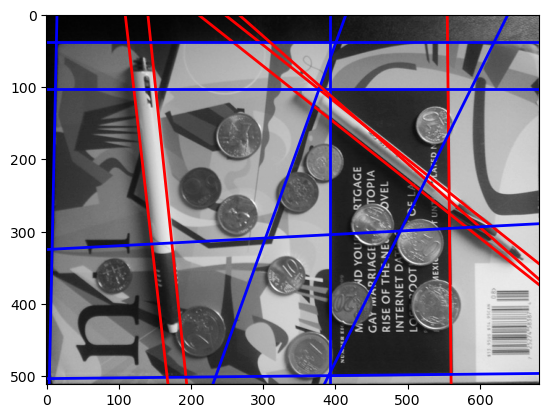

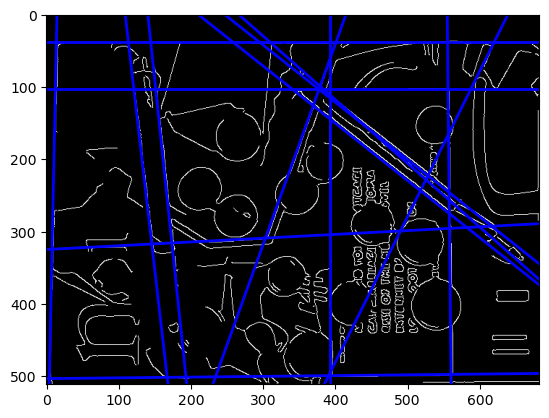

[(130.8853369259606, 2.4713862208239705), (14.22666705716963, 1.5498523757709646), (153.648004217432, 2.4713862208239705), (0.0, 2.5237460983838007), (554.8400152296156, 1.5812683023068623), (0.0, 2.4399702942880723), (0.0, 2.691297706575256), (139.42133716026237, 1.6755160819145563), (503.62401382380483, 0.010471975511965978), (36.98933434864104, 0.0), (389.81067736644786, 1.2252211349000193), (392.6560107778818, 1.5707963267948966), (108.1226696344892, 1.6859880574265222), (0.0, 2.356194490192345), (102.43200281162133, 0.0), (543.4586815838799, 3.036872898470133), (176.4106715089034, 2.419026343264141), (571.9120156982192, 1.1100294042683936), (0.0, 2.7750735106709836), (324.36800890346757, 0.05235987755982988)]


In [63]:
lines=hough(edges,ps1in2,300,300,True,20,8,verbose=False,showRadius=True)
#the hough arguments are edgeImage,originalImg,total_d_Divisions,angleDivisions,avoidCloseLines,totalLines,radius,verbose=False,showRadius=False
print(lines)



/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:22: RuntimeWarning: invalid value encountered in divide
  point2=vector+normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)
/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:23: RuntimeWarning: invalid value encountered in divide
  point1=vector-normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)


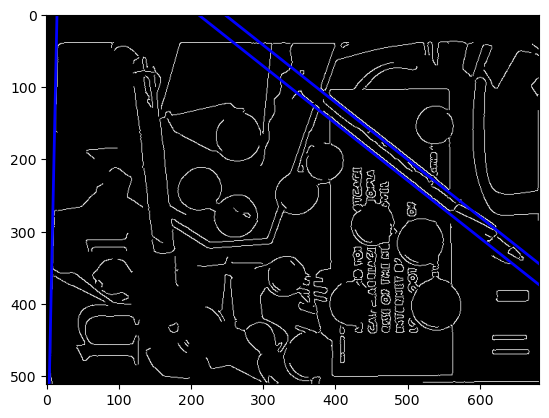

In [64]:
#print only the first four lines from lines on the img



#the top twenty lines dist and angle are in lines








hasAparallelLines=np.zeros(len(lines))

for l in range(len(lines)):
    for k in range(len(lines)):
        if l!=k:
            if abs(lines[l][1]-lines[k][1])<100 and abs(lines[l][0]-lines[k][0])<100000:
                hasAparallelLines[l]+=1

linesToDraw=[]
for i in range(len(lines)):
    if hasAparallelLines[i]>0:
        linesToDraw.append(lines[i])



from matplotlib.collections import LineCollection
counter=0
plt.imshow(edges,cmap='gray')
for l1 in [distAndAngleToLine(linesToDraw[0][0],linesToDraw[0][1],img.shape),distAndAngleToLine(linesToDraw[1][0],linesToDraw[1][1],img.shape),distAndAngleToLine(linesToDraw[2][0],linesToDraw[2][1],img.shape),distAndAngleToLine(linesToDraw[3][0],linesToDraw[3][1],img.shape)]:
    lc = LineCollection([l1], color='blue', lw=2)
    counter+=1

    plt.gca().add_collection(lc)
plt.show()





# TLDR : I couldn't get this to work entirely (detecting the 4 lines that are the pen borders)

# Moving on to question 7a

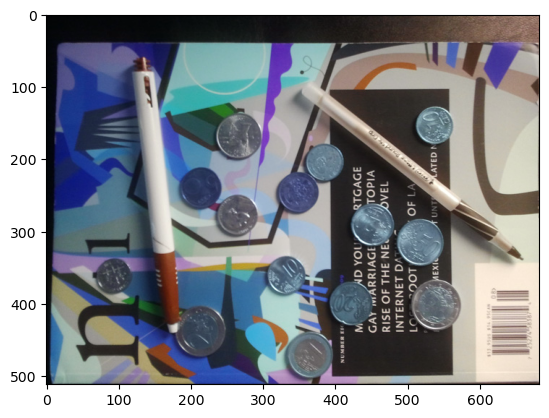

(512, 683)


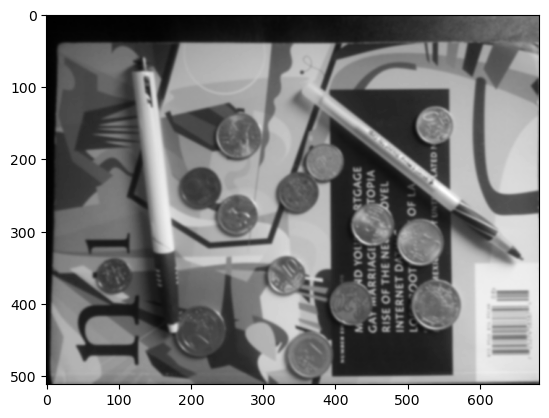

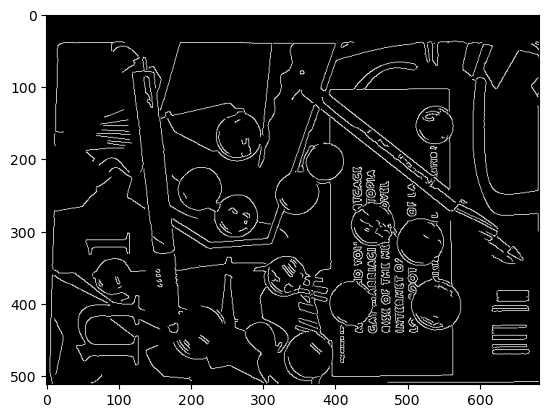

In [67]:
#now we want to find stronger edges, check the lines are not too short, and look for other nearby parallel lines

ps1in2=cv2.imread('ps1-input2.jpg',cv2.IMREAD_UNCHANGED)

#copy
ps1in2copy=ps1in2.copy()

#first let's pre=process to find the edges

plt.imshow(ps1in2)
plt.show()

ps1in2=cv2.cvtColor(ps1in2, cv2.COLOR_BGR2GRAY)

print(ps1in2.shape)

blurred=cv2.GaussianBlur(ps1in2,(7,7),1.4)

plt.imshow(blurred,cmap='gray')
plt.show()
#apply canny edge detection
edges = cv2.Canny(blurred,78,120)





plt.imshow(edges,cmap='gray')
plt.show()




(70, 400, 600)
ABOVE IS THE SHAPE OF ACC WE ARE SEARCHING IN WITHOUT RESTRCITIONS ON R
[[634.12871034]
 [634.10059172]
 [548.8       ]
 [520.90253634]
 [484.23529412]
 [493.65870617]
 [405.3172003 ]
 [492.61721068]
 [423.73538012]
 [383.65046423]
 [362.68911623]
 [252.01424695]
 [402.31299639]
 [449.90189746]
 [275.24257932]
 [223.65563506]
 [233.57963568]
 [253.01654412]
 [258.37677662]
 [232.50168919]
 [238.01556324]
 [260.47228981]
 [253.68272775]
 [241.90714658]
 [232.56569709]
 [251.55193925]
 [263.63615691]
 [242.85729248]
 [234.9599684 ]
 [241.83870968]
 [247.40515807]
 [238.79630621]
 [293.46809211]
 [227.33297985]
 [197.76291513]
 [218.75      ]
 [245.28032037]
 [243.05555556]
 [221.69079628]
 [236.03082852]]
[[ 27 312 370]
 [ 31 246 454]
 [ 20 119 471]
 [ 20 159 338]
 [ 35 314 473]
 [ 27 217 230]
 [ 27 226 396]
 [ 27 188 186]
 [ 31 367 321]
 [ 21 282 291]
 [ 29 131 233]
 [  1 270 387]
 [ 19 283  81]
 [ 25 194 303]
 [ 13 280 393]
 [  0 189 384]
 [  2 257 386]
 [  0 179 387]
 [

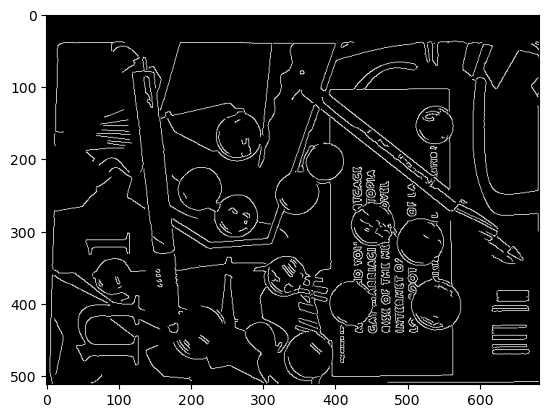

below is rxy
20 280 421
below is rxy
29 131 233
below is rxy
21 282 291
below is rxy
19 283 81
below is rxy
27 226 396
below is rxy
31 367 321
below is rxy
25 194 303
below is rxy
35 314 473
below is rxy
27 188 186
below is rxy
27 217 230
below is rxy
20 159 338
below is rxy
20 119 471
below is rxy
31 246 454
below is rxy
27 312 370


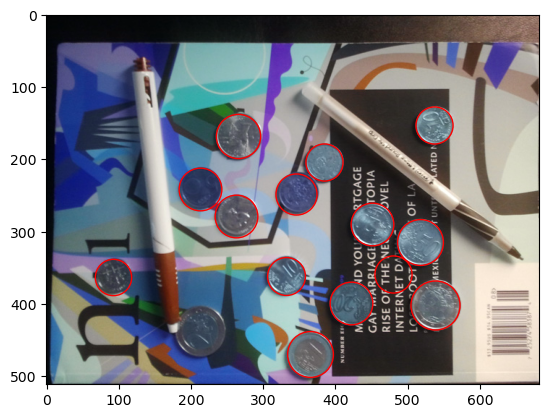

In [69]:


acc=houghCircle(edges,ps1in2copy,GRIDX,GRIDY,GRIDR,THETADIVS,MAXR,True,1,verbose=False,showRadiusBlackedOut=False)




MIN_R = 25
MAX_R = 68
maxx=searchSpace(MIN_R,MAX_R,acc,40,14,radius=8)





ORIGINAL=ps1in2copy


#draw the circles
counter=0
plt.imshow(edges,cmap='gray')
plt.show()
for i in range(len(maxx)):
    thismax=maxx[i][0]

    r=thismax[0]
    x=thismax[1]
    y=thismax[2]
    
    print("below is rxy")
    print(r,x,y)
    if(counter==0):
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageStart=True)
    elif counter==len(maxx)-1:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageEnd=True)
    else:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR)


In [70]:
for i in range(acc.shape[0]):

        #save 2d slice in npy file

        np.save('fileLONG'+str(i)+'.npy', acc[i,:,:])


## The coin finder works surprisingly well ! 

Unfortunately, it takes 15 minutes (On my old macbook ( and my poorly optimized code...)) to calculate a precise 3d hough space

There is one "false alarm" here as I asked the algorithm to find a total number of circles = to the number in the picture, and it didn't get one so it "found" it elswhere which is a false alarm.

To get rid of it we could need a better edge image, or a fine-tuning of the parameters of the algorithm.

# 8 - Sensitivity to distorsion

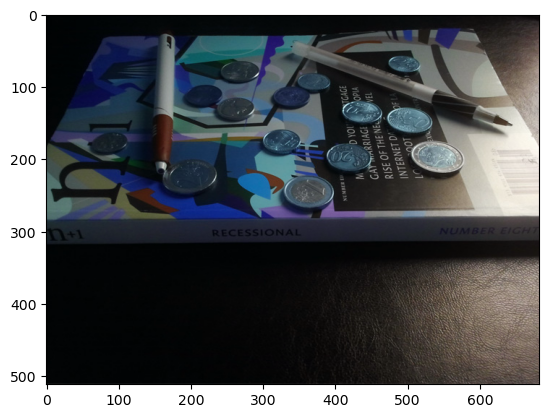

(512, 683)


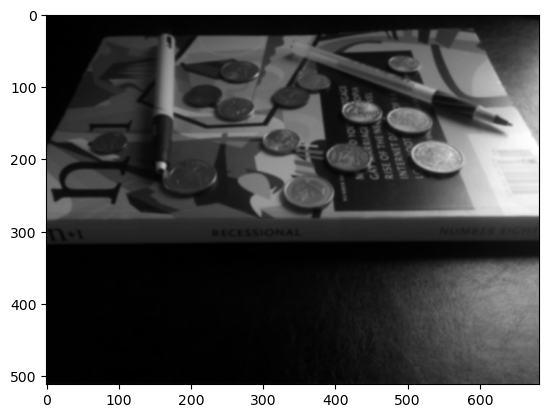

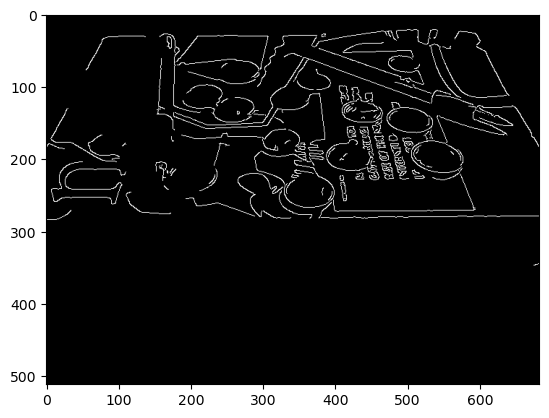

In [76]:
#now we want to find stronger edges, check the lines are not too short, and look for other nearby parallel lines

ps1in3=cv2.imread('ps1-input3.jpg',cv2.IMREAD_UNCHANGED)

#first let's pre=process to find the edges

plt.imshow(ps1in3)
plt.show()

ps1in3=cv2.cvtColor(ps1in3, cv2.COLOR_BGR2GRAY)

print(ps1in3.shape)

blurred=cv2.GaussianBlur(ps1in3,(23,23),1.3)

plt.imshow(blurred,cmap='gray')
plt.show()
#apply canny edge detection
edges = cv2.Canny(blurred,78,120)





plt.imshow(edges,cmap='gray')
plt.show()




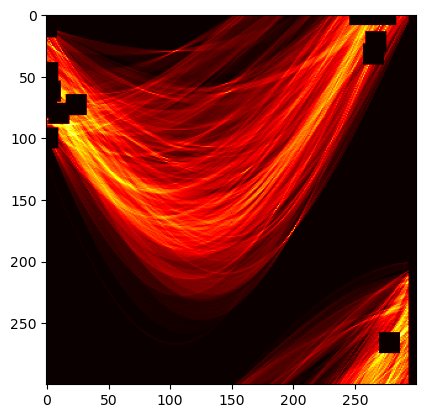

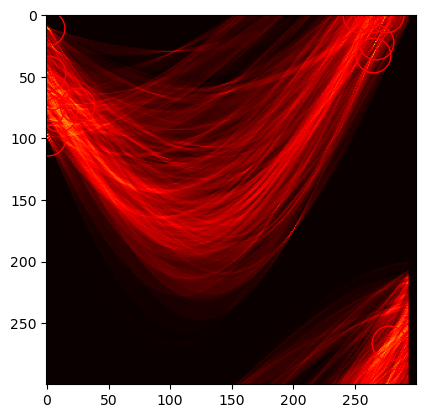

/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:22: RuntimeWarning: invalid value encountered in divide
  point2=vector+normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)
/var/folders/7w/q0yw3hqs6kd8gppcxzf_yn480000gn/T/ipykernel_11452/3109125257.py:23: RuntimeWarning: invalid value encountered in divide
  point1=vector-normalVector*max(xSize,ySize)*3/np.linalg.norm(normalVector)


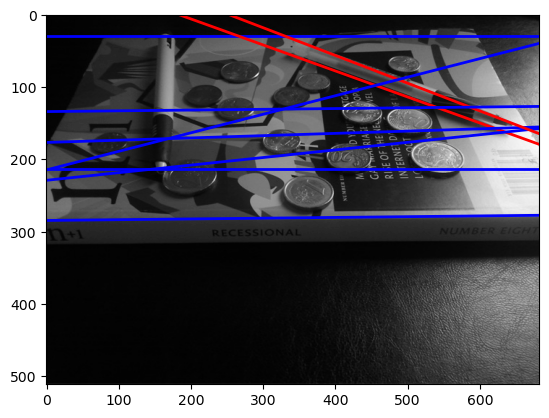

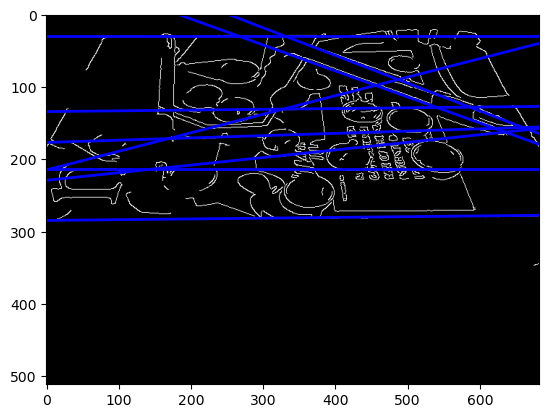

[(284.5333411433926, 0.010471975511965978), (0.0, 2.8797932657906435), (28.45333411433926, 0.0), (0.0, 2.764601535159018), (62.597335051546374, 2.796017461694916), (176.4106715089034, 0.031415926535897934), (0.0, 2.6598817800393584), (756.8586874414243, 2.9112091923265417), (213.40000585754444, 0.0), (227.62667291471408, 0.10471975511965977), (91.05066916588564, 2.7750735106709836), (133.7306703373945, 0.010471975511965978), (207.7093390346766, 0.25132741228718347)]


In [79]:
lines=hough(edges,ps1in3,300,300,True,13,9,verbose=False,showRadius=True)
#the hough arguments are edgeImage,originalImg,total_d_Divisions,angleDivisions,avoidCloseLines,totalLines,radius,verbose=False,showRadius=False
print(lines)


#print only the first four lines from lines on the img



#the top twenty lines dist and angle are in lines






### The top 13 lines are displayed, some are definitely good, some are more random


### For circles, I can't really tweak anything because of the huge compute time, so this final image is my best shot

In [ ]:
MIN_R = 20
MAX_R = 65

dacc=houghCircle(edges,ps1in3,GRIDX,GRIDY,GRIDR,THETADIVS,MAXR,True,1,verbose=False,showRadiusBlackedOut=False)





maxx=searchSpace(MIN_R,MAX_R,dacc,40,14,radius=8)





ORIGINAL=ps1in3


#draw the circles
counter=0
plt.imshow(edges,cmap='gray')
plt.show()
for i in range(len(maxx)):
    thismax=maxx[i][0]

    r=thismax[0]
    x=thismax[1]
    y=thismax[2]
    
    print("below is rxy")
    print(r,x,y)
    if(counter==0):
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageStart=True)
    elif counter==len(maxx)-1:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR,newImageEnd=True)
    else:
        displayCirclesOnOriginalImage([[x,y]],r+MIN_R,ORIGINAL,GRIDX,GRIDY,GRIDR,MAXR)
